In [39]:
### IMPORTS ###

# Quantum libraries:
import pennylane as qml
#from pennylane 
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

# Plotting
from matplotlib import pyplot as plt
import plotly

# Other
import sys, os
import time
import copy
import tqdm
import joblib # Writing and loading
from noisyopt import minimizeSPSA
import optuna # Automatic tuning tool
import multiprocessing

import warnings
warnings.filterwarnings("ignore", message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.")
##############


In [40]:
# My functions:
sys.path.insert(0, '../')
import vqe_functions as vqe
import qcnn_functions as qcnn


In [41]:
N = 8
J = 1


In [47]:
# Load data and separate in training and test set
data = joblib.load('../vqe_states_job/0noiseN'+str(N)+'.job')

train_index = np.sort(np.random.choice(np.arange(len(data)), size=int(0.8*len(data)), replace=False ))

X_train, Y_train = [], []
X_test, Y_test   = [], []
X, Y             = [], []
for i in range(len(data)): 
    if i in train_index:
        X_train.append(data[i][0])
        Y_train.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
    else:
        X_test.append(data[i][0])
        Y_test.append(data[i][1])
        X.append(data[i][0])
        Y.append(data[i][1])
        
X_train, Y_train = jnp.array(X_train), jnp.array(Y_train)
X_test, Y_test   = jnp.array(X_test), jnp.array(Y_test)


print('CLEAN DATA:')
print('______________________________')
print('Size of Data Set: {0}'.format(len(data)))
print('Size of Training Set: {0}'.format(np.shape(X_train)[0]))
print('Size of Test Set    : {0}'.format(np.shape(X_test)[0]))

CLEAN DATA:
______________________________
Size of Data Set: 100
Size of Training Set: 80
Size of Test Set    : 20


In [48]:
vqe_circuit_fun = vqe.vqe_circuit
qcnn_circuit_fun = qcnn.qcnn_circuit

sizes_train = [1, 10, 25, 50, 60, 70, 80]
epochs  = 3000
n_iters = 10
lr      = 0.05

In [49]:
device = qml.device("default.qubit.jax", wires = N, shots = None)

* 1. Split Test and Training set as 20-80 (This was not done randomly, the split was done so the test points are as sparse (and different) as possible)
* 2. We choose different sizes of the training set [npoints_list]
* 3. For npoints in npoints_list:
    * Draw randomly a subset of npoints from the training set
    * Train the QCNN just with those samples
    * Get the Loss and Accuracy on the Test Set
    * Get the mean and variance for the QCNNs trained with npoitns

In [50]:
def reduced_npoints_accuracies(X_train, Y_train, X_test, Y_test, device, npoints_list, n_iters, epochs, testdata_ratio = 0.2, plot = True):
    '''
    From the same VQE parameters we want to train many times a QCNN with different samples
    in order to find what is the average accuracy n-training points can reach
    '''
    
    @qml.qnode(device, interface="jax")
    def qcnn_circuit_prob(params_vqe, params, N):
        qcnn_circuit_fun(params_vqe, vqe_circuit_fun, params, N)
    
        return qml.probs(wires = N - 1)
    
    def compute_cross_entropy(X, Y, params):
        v_qcnn_prob = jax.vmap(lambda v:  qcnn_circuit_prob(v, params, N) )

        predictions = v_qcnn_prob(X)
        logprobs = jnp.log(predictions)

        nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
        ce = -jnp.mean(nll)

        return ce
    
    def compute_cross_entropy_n_accuracy(X, Y, params):
        v_qcnn_prob = jax.vmap(lambda v:  qcnn_circuit_prob(v, params, N) )

        predictions = v_qcnn_prob(X)
        logprobs = jnp.log(predictions)

        nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
        ce = -jnp.mean(nll)

        return ce, 100*jnp.sum(jnp.argmax(predictions, axis = 1) == Y)/len(Y)
    
    test_get_results  = jax.jit(lambda p: compute_cross_entropy_n_accuracy(X_test, Y_test, p) ) 
    wrap_jax_train = lambda x,y: jax_train(epochs, lr, N, device, vqe_circuit_fun, qcnn_circuit_fun, x, y)
    
    loss_means = []
    loss_devs  = []
    
    acc_means = []
    acc_devs  = []
    
    for prog, npoints in enumerate(npoints_list):
        pbar = tqdm.tqdm(total = n_iters, position=0, leave=True)
        pbar.set_description('{0}/{1}'.format(prog+1, len(npoints_list)) )
        
        d_compute_cross_entropy = jax.jit(jax.grad(lambda p, X_sub, Y_sub: compute_cross_entropy(X_sub, Y_sub, p) ) )
        
        # Training function
        def jax_train(epochs, lr, N, device, vqe_circuit_fun, qcnn_circuit_fun, X_sub, Y_sub):
        
            n_params = qcnn_circuit_fun([0]*1000, vqe_circuit_fun, [0]*1000, N)
            params = np.array([np.pi/4]*n_params)

            for epoch in range(epochs):
                params -= lr*d_compute_cross_entropy(params, X_sub, Y_sub)

            return params
        
        loss_point, acc_point = [], []
            
        for it in range(n_iters):
            # Choose a random subset of the training set of size npoints
            train_idx_it = np.random.choice(np.arange(len(Y_train)), npoints, replace=False)
            X_train_it = jnp.array(X_train[train_idx_it])
            Y_train_it = jnp.array(Y_train[train_idx_it])
            
            params = wrap_jax_train(X_train_it, Y_train_it)
            
            pbar.update(1)
            
            loss, acc = test_get_results(params)
            loss_point.append(loss)
            acc_point.append(acc)
            
        loss_means.append(np.mean(loss_point))
        loss_devs.append(np.std(loss_point))
    
        acc_means.append(np.mean(acc_point))
        acc_devs.append(np.std(acc_point))
        
    
    if plot:
        fig, ax = plt.subplots(2, 1, figsize=(10,10))
            
        ax[0].plot(np.arange(len(npoints_list)), loss_means, color='indigo', lw = 2, alpha = 0.3)
        ax[0].errorbar(np.arange(len(npoints_list)), loss_means, yerr=3*np.array(loss_devs), fmt='o', color='indigo',
                       ecolor='blueviolet', elinewidth=3, capsize=0)
        ax[0].set_xticks(np.arange(len(npoints_list)))
        ax[0].set_xticklabels(npoints_list)
        ax[0].grid(True)
        ax[0].set_title('Losses on Test Set'.format(N,J))
        ax[0].set_xlabel('# points in Training Set')
        ax[0].set_ylabel('Cross-entropy')

        ax[1].plot(np.arange(len(npoints_list)), acc_means, color='red', ms = 7, alpha = 0.3)
        ax[1].errorbar(np.arange(len(npoints_list)), acc_means, yerr=3*np.array(acc_devs),fmt='o', color='red',
                       ecolor='red', elinewidth=3, capsize=0)
        ax[1].set_xticks(np.arange(len(npoints_list)))
        ax[1].set_xticklabels(npoints_list)
        ax[1].grid(True)
        ax[1].set_title('Accuracies on Test Set')
        ax[1].set_xlabel('# points in Training Set')
        ax[1].set_ylabel('(%)')
        
    return loss_means, loss_devs, acc_means, acc_devs


7/7: 100%|██████████████████████████████████████| 10/10 [01:42<00:00, 10.26s/it]


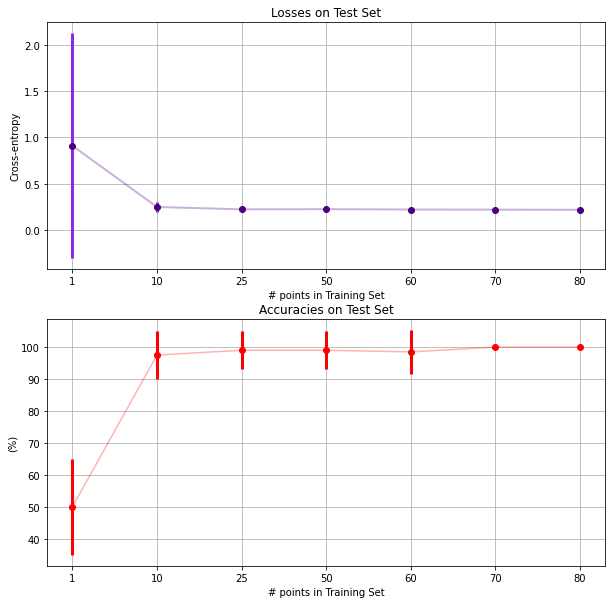

In [51]:
loss_means, loss_devs, acc_means, acc_devs = reduced_npoints_accuracies(X_train, Y_train, X_test, Y_test, device, sizes_train, n_iters, epochs,
                               testdata_ratio = 0.2, plot = True)

In [52]:
joblib.dump((loss_means, loss_devs), '../../data/small_sets/loss.job')
joblib.dump((acc_means, acc_devs), '../../data/small_sets/acc.job')

['../../data/small_sets/acc.job']

joblib.dump((loss_means, loss_devs), '/data/smonaco/loss.job')
joblib.dump((acc_means, acc_devs), '/data/smonaco/acc.job')